In [29]:
import os
os.environ["XUVTOP"] = "/usr/local/ssw/packages/chianti/dbase/"
from scipy.io import readsav
import xarray as xr
import numpy as np
from dateutil.tz import gettz
from datetime import datetime
from datetime import date
import dask, pdb, copy
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

from muse.synthesis.synthesis import vdem_synthesis, vdem_syn_join_slits_wvl, ph2e, exposure_time
from muse.instr.psf import  convolve_model_psf, oversampled_wavelength_to_sg
from muse.instr.gausslobes import gausslobes
from muse.instr.detect_sidelobes import remove_yx_sidelobes
from muse.instr.utils import create_eff_area_xarray, ci2sg_response_format
from muse.instr import mono_diffraction
from muse.transforms.transforms import reshape_x2rs
from muse.utils.utils import  deweight_func, sub_contaminants, read_response, weight_func
from muse.instr.utils import sum_lines_per_band, sum_lines_slits_per_band
from muse.inversions.inversions import vdem_solve

from muse.utils.fitting import masker
from muse.variables import CENTROID_UNCERT_PROMISED, EXP_NOM
from muse.utils.fitting import gaussian_fitting_analysis,calculate_moments_gaussian
from muse.utils.fitting import main_gaussian_fitter,_vet_new_local_max,fit_gaussian
from muse.utils.fitting import fit_gaussian_remove_badspec,local_max
from muse.utils.miscellaneous import plot_gfat2c, generate_outliers_newer, get_outliers_newer, plot_with_chisquare

from sklearn.linear_model import Ridge as Ridge
from sklearn.linear_model import LassoLars as LassoLars
author="JMS"
WEST = gettz("US/Western")

In [30]:
fig_path = '/home/ec2-user/SageMaker/code/paper/'
data_path = '/home/ec2-user/SageMaker/data/565000/'
response= xr.open_zarr(data_path + 'response_565000.zarr').compute()
response["line"] = ['Fe XIX', 'Fe XXI', '108 missing main line', 'Fe IX',
                    '171 missing main line', 'Fe XV', '284 missing main line']

if False:
    spec_gt = xr.open_zarr(data_path+'spec_m-flare-muram_los2_trac_565000_core.zarr').compute()
    spec_gt["flux"].attrs = dict(units="ph / s")
    spec_gt["gain"] = xr.DataArray([10]*3, dims=['band'])
    spec_obs = sum_lines_slits_per_band(spec_gt)
    spec_obs.to_zarr(data_path+'spec_obs.zarr', mode='w')
    
    spec_gt_70lpi = xr.open_zarr(data_path+'spec_m-flare-muram_los2_trac_565000_70LPI.zarr').compute()
    # except 284 band, no diffraction patterns
    spec_gt_70lpi["flux"].attrs = dict(units="ph / s")
    spec_gt_70lpi["gain"] = xr.DataArray([10]*3, dims=['band'])
    spec_obs_70lpi = sum_lines_slits_per_band(spec_gt_70lpi)
    spec_obs_70lpi.to_zarr(data_path+'spec_obs_70lpi.zarr', mode='w')
else:
    spec_obs = xr.open_zarr(data_path+'spec_obs.zarr').compute()
    spec_obs_70lpi = xr.open_zarr(data_path+'spec_obs_70lpi.zarr').compute()

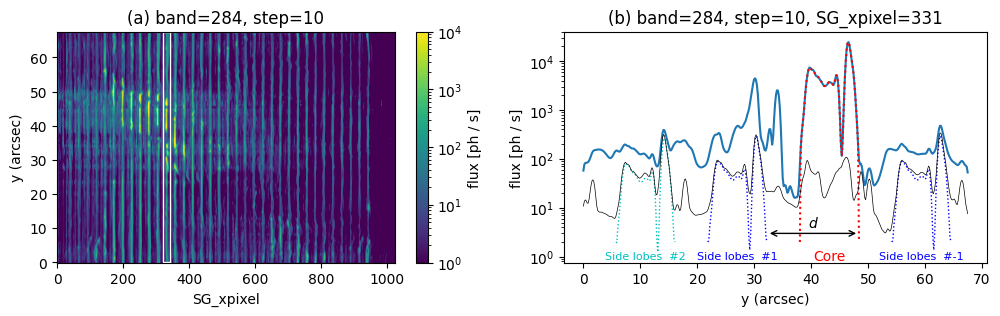

In [31]:
from muse.instr import detect_sidelobes as ds
norm = colors.PowerNorm(0.3, 0, 1e4)
norm = colors.LogNorm(1, 1e4)

dum = spec_obs_70lpi.isel(band=2).flux
max_loc = dum.where(dum.max() == dum, drop=True).squeeze()
max_band = 284
max_x = 52.8
max_step = int(np.mod((max_x/0.4), 11))
max_slit = int((max_x/0.4)//11)
max_SG_xpixel = np.argmin(abs(response.SG_wvl.isel(line=6, slit=max_slit).data - 284.163))
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
dum.sel(step=max_step).plot(norm=norm, ax=ax[0], extend='neither')
ax[0].set(title=f'(a) band={max_band}, step={max_step}', ylabel='y (arcsec)')
box_width = -10
ax[0].plot(np.array([max_SG_xpixel]*5) + np.array([-1, 1, 1, -1, -1])*box_width, 
           [dum.y.min(), dum.y.min(), dum.y.max(), dum.y.max(), dum.y.min()], 
           color='white', lw=1)
dum.sel(SG_xpixel=max_SG_xpixel, step=max_step).plot(yscale='log', ax=ax[1])
ax[1].set(title=f'(b) band={max_band}, step={max_step}, SG_xpixel={max_SG_xpixel}', xlabel='y (arcsec)')
data = dum.sel(SG_xpixel=max_SG_xpixel, step=max_step).data
y = dum.y.data
peak_ind = np.argmax(data)
# peak_ind = 250
thres = 1e2
left = np.where(data[:peak_ind] < 1e2)[0].max() + 1
right = np.where(data[peak_ind:] < 1e2)[0].min() + peak_ind
dist = ds.gl_dist(284.163, arcsec=True)

core = copy.deepcopy(data[left-1:right+1])
core[0] = 2
core[-1] = 2
y_core = y[left-1:right+1]

ax[1].plot(y_core, core, ':r')
ax[1].text(np.mean(y_core), 1, 'Core', color='r', va='center', ha='center')
for i_, i in enumerate([-1, 1, 2]):
    color = 'bbc'[i_]
    dum = core*ds.gl_peak()[abs(i)]
    dum[[0, -1]] = 2
    # ax[1].plot(y_core - dist*i, core*ds.gl_peak()[abs(i)], ':r', lw=1)
    ax[1].plot(y_core - dist*i, dum, f':{color}', lw=1)
    ax[1].text(np.mean(y_core - dist*i), 1, f'Side lobes  #{i}', 
               va='center', ha='center', color=color, size=8)

ax[1].plot(y, data - spec_obs.flux.isel(band=2, SG_xpixel=max_SG_xpixel, step=max_step).data, 
           lw=0.5, color='black')
# ax[1].annotate('', xy=(np.mean(y_core)-dist, 3), xytext=(np.mean(y_core), 3), arrowprops=dict(arrowstyle='<->'))
# ax[1].text(np.mean(y_core)-dist*0.5, 5, '$d$', 
#                va='center', ha='center', color='k')
ax[1].annotate('', xy=(y_core[-1]-dist, 3), xytext=(y_core[-1], 3), arrowprops=dict(arrowstyle='<->'))
ax[1].text(y_core[-1]-dist*0.5, 5, '$d$', 
               va='center', ha='center', color='k')

plt.savefig(fig_path+'yx_removal_example.png', dpi=200, bbox_inches='tight')

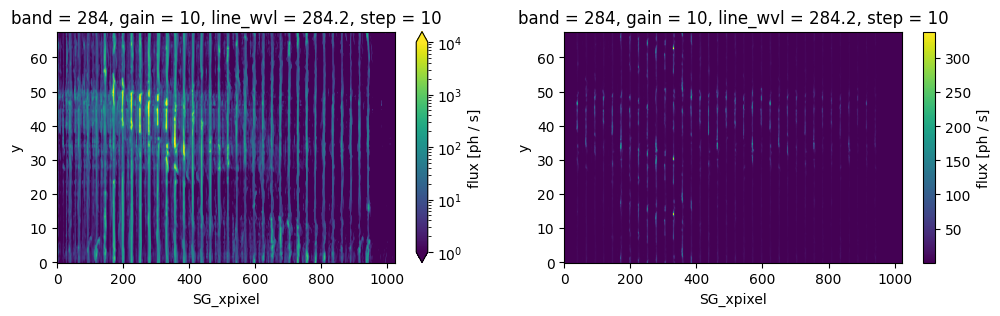

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
spec_obs_70lpi.isel(band=2).flux.sel(step=max_step).plot(norm=colors.LogNorm(1, 1e4), ax=ax[0])
(spec_obs_70lpi - spec_obs).isel(band=2).flux.sel(step=max_step).plot(ax=ax[1])
fig.savefig(fig_path+'spec_example.png', dpi=200, bbox_inches='tight')

In [32]:
def trans_ax2ax(pos_in_ax1, ax1, ax2):
    data_co = ax1.transData.transform(pos_in_ax1)
    return ax2.transData.inverted().transform(data_co)

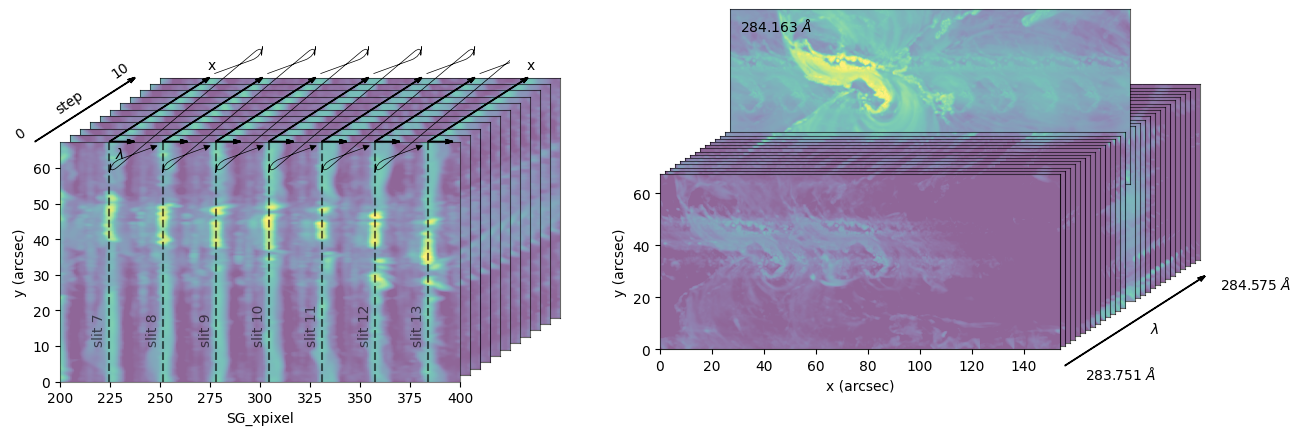

In [121]:
import matplotlib.patches as mpatches
norm1 = colors.PowerNorm(0.3, 0, 1e4)
norm1 = colors.LogNorm(1, 1e4)
cube = mono_diffraction.create_xyw_cube(spec_obs_70lpi, response).isel(line=0)

dum = spec_obs_70lpi.isel(band=2).flux
max_loc = dum.where(dum.max() == dum, drop=True).squeeze()
max_band = 284
max_x = 52.8
max_step = int(np.mod((max_x/0.4), 11))
max_slit = int((max_x/0.4)//11)

fig = plt.figure(figsize=(10, 4))
ax00 = fig.add_axes((0, 0, 0.5, 1), zorder=10, xlim=[0, 1], ylim=[0, 1])
ax00.set_axis_off()
ax01 = fig.add_axes((0.05, 0.1, 0.4, 0.6))
ax01_bbox = ax01.get_position()
ax01_pos = [ax01_bbox.x0, ax01_bbox.y0, ax01_bbox.width, ax01_bbox.height]
im01 = ax01.imshow(dum[0], norm=norm1, 
                   extent=[*spec_obs_70lpi.SG_xpixel.data[[0, -1]], 
                           *spec_obs_70lpi.y.data[[0, -1]]], alpha=0.6)
ax01.set(aspect='auto', ylabel='y (arcsec)', xlabel='SG_xpixel', xlim=[200, 400], 
        zorder=5, clip_on=False)
ax01.spines[['top', 'bottom', 'right', 'left']].set_alpha(0.5)
ax0n = [ax01]
for i in range(10, 0, -1):
    ax0n0 = fig.add_axes(([ax01_bbox.x0+0.01*i, ax01_bbox.y0+0.016*i, 
                           ax01_bbox.width, ax01_bbox.height]))
    im0n = ax0n0.imshow(dum[i], norm=norm1, 
                   extent=[*spec_obs_70lpi.SG_xpixel.data[[0, -1]], 
                           *spec_obs_70lpi.y.data[[0, -1]]], alpha=0.6)
    ax0n0.set(aspect='auto', xticks=[], yticks=[], xlim=ax01.get_xlim())
    ax0n0.spines[['top', 'bottom', 'right', 'left']].set_alpha(0.6)
    ax0n.append(ax0n0)
SG_wvl = response.SG_wvl.isel(line=6)
slit_loc = [np.interp(284.163, SG_wvl.isel(slit=i), SG_wvl.SG_xpixel) for i in SG_wvl.slit]
for i in range(7, 14):
    p01 = ax0n[0].plot([slit_loc[i]]*2, ax01.get_ylim(), '--', color='k', alpha=0.6)
    t04 = ax0n[0].text(slit_loc[i]-5, 10, f'slit {i}',
                       rotation=90, va='bottom', ha='center', alpha=0.6)
    pos0 = trans_ax2ax((slit_loc[i], dum.y.max()), ax0n[0], ax00)
    pos1 = trans_ax2ax((slit_loc[i], dum.y.max()), ax0n[1], ax00)
    ar01 = ax00.arrow(pos0[0], pos0[1], pos1[0]-pos0[0], pos1[1]-pos0[1], 
                     head_width=0.01, length_includes_head=True, color='k', 
                     overhang=1, clip_on=False)
    if i < 13:
        pos2 = trans_ax2ax((slit_loc[i+1], dum.y.max()), ax0n[0], ax00)
        init = np.array((pos1[0]+0.01, pos1[1]+0.01))
        fina = np.array((pos2[0]-0.01, pos2[1]-0.01))
        mid = 0.5*(init + fina)
        con12 = mpatches.ConnectionPatch(
            init, mid, 
            coordsA="data", coordsB="data",
            arrowstyle="-", color='k', linestyle='-', lw=0.5,
            connectionstyle='arc,angleA=20, angleB=40, rad=10, armA=50, armB=100', 
            clip_on=True,
            axesA=ax00, axesB=ax00)
        ax00.add_artist(con12)
        con13 = mpatches.ConnectionPatch(
            mid, fina, 
            coordsA="data", coordsB="data",
            arrowstyle="-|>", color='k', linestyle='-', lw=0.5,
            connectionstyle='arc,angleA=220, angleB=200, rad=10, armA=100, armB=50', 
            clip_on=True,
            axesA=ax00, axesB=ax00)
        ax00.add_artist(con13)
        # con12 = mpatches.ConnectionPatch(
        #     (pos1[0]+0.01, pos1[1]), (pos2[0]-0.01, pos2[1]), 
        #     coordsA="data", coordsB="data",
        #     arrowstyle="-|>", color='k', linestyle='-', lw=0.5,
        #     connectionstyle='arc,angleA=45, angleB=225, rad=40, armA=50, armB=50', 
        #     clip_on=True,
        #     axesA=ax00, axesB=ax00)
        # ax00.add_artist(con12)
    ar03 = ax00.arrow(pos0[0], pos0[1], 0.05, 0,
                      head_width=0.01, length_includes_head=True, color='k', overhang=1)
    if i == 7:
        t02 = ax00.text(pos0[0]+0.02, pos0[1]-0.03, 
                        '$\lambda$', va='center', ha='center')
    if i == 7 or i == 13:
        t03 = ax00.text(pos1[0]+0.005, pos1[1]+0.03, 
                        'x', va='center', ha='center')        
pos00 = trans_ax2ax((ax01.get_xlim()[0], dum.y.max()), ax0n[0], ax00)
pos01 = trans_ax2ax((ax01.get_xlim()[0], dum.y.max()), ax0n[1], ax00)
ar04 = ax00.arrow(pos00[0]-0.05, pos00[1], pos01[0]-pos00[0], pos01[1]-pos00[1], 
                 head_width=0.01, length_includes_head=True, color='k', 
                 overhang=1)
t01 = ax00.text(pos00[0]-0.08+0.5*(pos1[0]-pos0[0]), 
                pos00[1]+0.5*(pos01[1]-pos00[1])+0.02, 
                'step', va='center', ha='center', rotation=35)
t011 = ax00.text(pos00[0]-0.08, pos00[1]+0.02, 
                '0', va='center', ha='center', rotation=35)
t012 = ax00.text(pos01[0]-0.08, pos01[1]+0.02, 
                '10', va='center', ha='center', rotation=35)

#---------------------
ax10 = fig.add_axes((0.6, 0, 0.5, 1), zorder=10, xlim=[0, 1], ylim=[0, 1])
ax10.set_axis_off()
ax10.set(alpha=0.2, position=[0, 0, 1, 1])
ax11 = fig.add_axes((0.65, 0.1, 0.4, 0.6))
ax11_bbox = ax11.get_position()
im11 = ax11.imshow(cube.flux.isel(wave=0), norm=norm1, 
                   extent=[*cube.x.data[[0, -1]], 
                           *cube.y.data[[0, -1]]], alpha=0.6)
ax11.set(aspect='equal', ylabel='y (arcsec)', xlabel='x (arcsec)', 
        zorder=5, clip_on=False)
ax11.spines[['top', 'bottom', 'right', 'left']].set_alpha(0.6)
ax1n = [ax11]
for i, wave in reversed(list(enumerate(cube.wave.data))):
    add = 0.3 if wave == cube.wave_cen else 0
    ax1n0 = fig.add_axes(([ax11_bbox.x0+0.005*i, ax11_bbox.y0+0.008*i+add, 
                           ax11_bbox.width, ax11_bbox.height]))
    im1n = ax1n0.imshow(cube.flux.isel(wave=i), norm=norm1, 
                   extent=im11.get_extent(), alpha=0.6)
    ax1n0.set(aspect='equal', xticks=[], yticks=[], xlim=ax11.get_xlim())
    ax1n0.spines[['top', 'bottom', 'right', 'left']].set_alpha(0.6)
    ax1n.append(ax1n0)
    if wave == cube.wave_cen:
        t_cen = ax1n0.text(ax1n0.get_xlim()[0]+4, 
                           ax1n0.get_ylim()[1]-3, 
                           f'{cube.wave_cen:.3f} $\AA$', va='top', ha='left')

pos10 = trans_ax2ax((ax11.get_xlim()[1], 0), ax1n[0], ax00)
pos11 = trans_ax2ax((ax11.get_xlim()[1], 0), ax1n[1], ax00)

ar14 = ax00.arrow(pos10[0]+0.01, pos10[1]+0.04, pos11[0]-pos10[0], pos11[1]-pos10[1], 
                 head_width=0.01, length_includes_head=True, color='k', 
                 overhang=1, clip_on=False)
t11 = ax00.text(0.5*(pos10[0]+pos11[0])+0.05, 
                0.5*(pos10[1]+pos11[1])+0.02, 
                '$\lambda$', va='center', ha='center')
t12 = ax00.text(pos10[0]+0.05, 
                pos10[1]+0.02, 
                f'{cube.wave[0]:.3f} $\AA$', va='center', ha='left')
t14 = ax00.text(pos11[0]+0.04, 
                pos11[1]+0.02, 
                f'{cube.wave[-1]:.3f} $\AA$', va='center', ha='left')

plt.savefig(fig_path+'mono_illustration.png', dpi=200, bbox_inches='tight')

In [33]:
norm = colors.PowerNorm(0.3, 0, 1e4)
npix = 2
velocity_range = 400
line = ['Fe XV']

In [34]:
def IDL_cmap(num):
    from matplotlib.colors import LinearSegmentedColormap, ListedColormap
    idl_cmap= np.load('/home/ec2-user/SageMaker/code/paper/all_colortables_values_idl.npy')
    return ListedColormap(idl_cmap[num].T/256.)

In [46]:
if False:
    mom_obs = gaussian_fitting_analysis(spec_obs, response, line_band_key=line,
                                       kwargs_obs={"npix": npix, "velocity_range": velocity_range})
    mom_obs.to_zarr(data_path+'mom_obs.zarr', mode='w')
    mom_obs_70lpi = gaussian_fitting_analysis(spec_obs_70lpi, response, line_band_key=line,
                                              kwargs_obs={"npix": npix, "velocity_range": velocity_range})
    mom_obs_70lpi.to_zarr(data_path+'mom_obs_70lpi.zarr', mode='w')
else:
    
    mom_obs = xr.open_zarr(data_path+'mom_obs.zarr').compute()
    mom_obs_70lpi = xr.open_zarr(data_path+'mom_obs_70lpi.zarr').compute()

In [47]:
if False:
    spec_yx_remove, slit_info = remove_yx_sidelobes(spec_obs_70lpi, response)
    spec_yx_remove.to_zarr(data_path+'spec_yx_remove.zarr', mode='w')
    mom_yx_remove = gaussian_fitting_analysis(spec_yx_remove, response, line_band_key=line,
                                              kwargs_obs={"npix": npix, "velocity_range": velocity_range})
    mom_yx_remove.to_zarr(data_path+'mom_yx_remove.zarr', mode='w')
else:
    spec_yx_remove = xr.open_zarr(data_path+'spec_yx_remove.zarr').compute()
    mom_yx_remove = xr.open_zarr(data_path+'mom_yx_remove.zarr').compute()

In [48]:
    spec_yx_remove, slit_info = remove_yx_sidelobes(spec_obs_70lpi, response)

In [35]:
    spec_mono_remove = mono_diffraction.remove_diffraction_mono(spec_obs_70lpi, response)

In [36]:
dum = mono_diffraction.create_xyw_cube(spec_obs_70lpi, response)

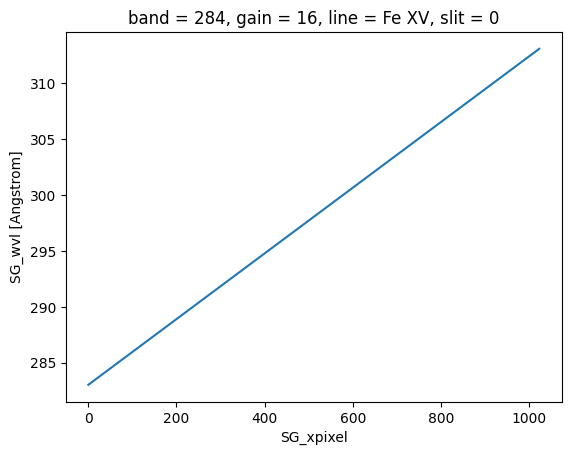

In [50]:
response.SG_wvl.isel(line=5, slit=0).plot()

In [51]:
response

<xarray.Dataset>
Dimensions:    (line: 7, vdop: 179, logT: 34, slit: 35, SG_xpixel: 1024)
Coordinates:
  * SG_xpixel  (SG_xpixel) int32 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
    band       (line) int64 108 108 108 171 171 284 284
    gain       (line) int64 16 16 16 16 16 16 16
  * line       (line) <U21 'Fe XIX' 'Fe XXI' ... 'Fe XV' '284 missing main line'
  * logT       (logT) float64 4.7 4.8 4.9 5.0 5.1 5.2 ... 7.6 7.7 7.8 7.9 8.0
  * slit       (slit) int32 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
  * vdop       (vdop) float64 -780.0 -770.0 -760.0 -750.0 ... 980.0 990.0 1e+03
Data variables:
    SG_resp    (line, vdop, logT, slit, SG_xpixel) float32 0.0 0.0 ... 5.118e-11
    SG_wvl     (line, slit, SG_xpixel) float32 107.7 107.7 107.7 ... 286.5 286.6
    line_wvl   (line) float32 108.4 108.1 108.4 171.1 171.1 284.2 284.2
Attributes: (12/15)
    ABUNDANCES:    sun_coronal_1992_feldman_ext.abund
    BAND_CUBES:    band_cubes_12974minors_p3e15_coronal_to2000kms-31Aug2021.sav
    DESCRIPTION:   MUSE response function, Fe XIX only, -/+1000 km/s, LogT 4....
    EFF_AREA:      SMX00044 muse_response_20160811.sav
    E_PRESSURE:    3000000028082176.0
    GOFT_FILE:     goft_p3e15-6Mar2021.sav
    ...            ...
    SG_BAND:       108
    SLIT_SEP_A:    0.3900400075912476
    SLIT_SEP_PIX:  26.53333333333333
    SLIT_WID_PIX:  2.3333332538604736
    UNITS:         photon counts/s from EM=10^27(cm^-5) at Log10(T/K), VDOP(k...
    VERSION:       made using muse-v1h.pro, Wed Apr 19 06:18:45 2023, mult304...

In [54]:
(dum.wave - dum.wave_cen)/dum.wave_cen*3e5

<xarray.DataArray (wave: 29)>
array([-434.53936398, -403.50083798, -372.46231199, -341.42378599,
       -310.38525999, -279.34673399, -248.30820799, -217.26968199,
       -186.23115599, -155.19262999, -124.154104  ,  -93.115578  ,
        -62.077052  ,  -31.038526  ,    0.        ,   31.038526  ,
         62.077052  ,   93.115578  ,  124.154104  ,  155.19262999,
        186.23115599,  217.26968199,  248.30820799,  279.34673399,
        310.38525999,  341.42378599,  372.46231199,  403.50083798,
        434.53936398])
Coordinates:
  * wave     (wave) float64 283.8 283.8 283.8 283.8 ... 284.5 284.5 284.5 284.6

In [58]:
aa = response.SG_wvl.isel(line=6)

In [60]:
response.SG_wvl.isel(line=6)

<xarray.DataArray 'SG_wvl' (slit: 35)>
array([298.06888, 297.2888 , 296.50873, 295.72864, 294.94855, 294.1685 ,
       293.3884 , 292.6083 , 291.82825, 291.04816, 290.26807, 289.488  ,
       288.70792, 287.92783, 287.14777, 286.36768, 285.5876 , 284.80753,
       284.02744, 283.24734, 282.4673 , 281.6872 , 280.90714, 280.12704,
       279.34695, 278.5669 , 277.7868 , 277.0067 , 276.22665, 275.44656,
       274.66647, 273.8864 , 273.10632, 272.32623, 271.54617],
      dtype=float32)
Coordinates:
    SG_xpixel  int32 512
    band       int64 284
    gain       int64 16
    line       <U21 '284 missing main line'
  * slit       (slit) int32 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34
Attributes:
    units:    Angstrom

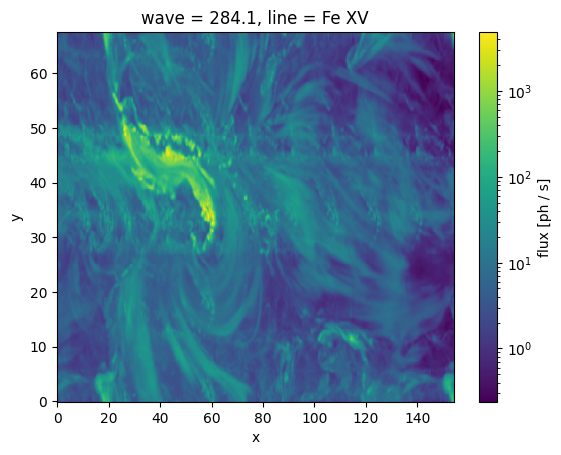

In [46]:
v = 100
dlambda = 100/3e5*284.16
dum.flux.sel(line='Fe XV', wave=284.16-dlambda, method='nearest').plot(norm=colors.LogNorm())

In [52]:
if False:
    spec_mono_remove = mono_diffraction.remove_diffraction_mono(spec_obs_70lpi, response)
    spec_mono_remove.to_zarr(data_path+'spec_mono_remove.zarr', mode='w')
    mom_mono_remove = gaussian_fitting_analysis(spec_mono_remove, response, line_band_key=line,
                                              kwargs_obs={"npix": npix, "velocity_range": velocity_range})
    mom_mono_remove.to_zarr(data_path+'mom_mono_remove.zarr', mode='w')
else:
    spec_mono_remove = xr.open_zarr(data_path+'spec_yx_remove.zarr').compute()
    mom_mono_remove = xr.open_zarr(data_path+'mom_mono_remove.zarr').compute()

In [53]:
spec_sub_1st = xr.open_zarr(data_path+'spec_sub_1st.zarr').compute()
mom_sub_1st = xr.open_zarr(data_path+'mom_sub_1st.zarr').compute()
spec_sub_2nd = xr.open_zarr(data_path+'spec_sub_2nd.zarr').compute()
mom_sub_2nd = xr.open_zarr(data_path+'mom_sub_2nd.zarr').compute()

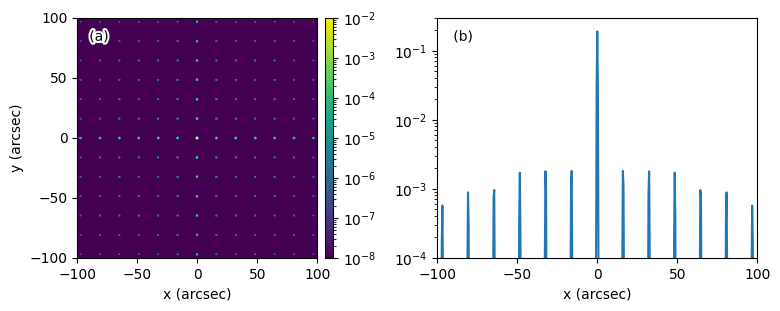

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
gl = gausslobes()
dx, dy = 0.4, 0.167
xp = np.arange(gl.shape[0])*dx
xp -= np.mean(xp)
yp = np.arange(gl.shape[1])*dy
yp -= np.mean(yp)
gl_ext = [xp[0]-dx, xp[-1]+dx, yp[0]-dy, yp[-1]+dy]
# im01 = axs[0].imshow(np.log10(gl+1e-20).T, vmin=-10, vmax=-2, 
#                      extent=gl_ext)
im01 = axs[0].imshow((gl+1e-10).T, 
                     extent=gl_ext, norm=colors.LogNorm(1e-8, 1e-2))

axs[0].set(xlabel='x (arcsec)', ylabel='y (arcsec)', 
           xticks=sorted(set(xp//50*50))[1:], yticks=sorted(set(yp//50*50))[1:], 
           aspect='equal', position=[0.05, 0.1, 0.3, 0.6], 
           xlim=[-100, 100], ylim=[-100, 100], 
          )
pos0 = axs[0].get_position()

cax0 = fig.add_axes([pos0.x1+0.01, pos0.y0, 0.01, pos0.height])
cb01 = fig.colorbar(im01, cax=cax0)

axs[1].plot(xp, gl[:, gl.shape[1]//2])
axs[1].set(
    yscale='log', 
    ylim=[1e-4, 3e-1], xlim=axs[0].get_xlim(), 
           position=[pos0.x1+0.15, pos0.y0, 0.4, pos0.height], xlabel='x (arcsec)')

for i, ax in enumerate(axs):
    ax.text(0.05, 0.95, fr'({chr(ord("a") + i)})', transform=ax.transAxes, 
            va='top', ha='left',
            path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")])
# axs[1].text(-90, 0.1, 'Y=0')

# fig.colorbar(im01, fraction=0.046, pad=0.04)


plt.savefig(fig_path+'gausslobes.png', dpi=200, bbox_inches='tight')

In [22]:
(70.*284.163*1e-10/0.0254)*180/np.pi*3600

16.153141061541557

In [55]:
from muse.utils.fitting import masker
from muse.utils.miscellaneous import get_outliers_newer
from muse.synthesis.synthesis import exposure_time 
exp_time = 0.6

mom_obs_exp = exposure_time(mom_obs, exp_time)
mask_obs = masker("auto", mom_obs_exp, line_band_list=['Fe XV'])

mom_obs_70lpi_exp = exposure_time(mom_obs_70lpi, exp_time)
mask_obs_70lpi = masker("auto", mom_obs_70lpi_exp, line_band_list=['Fe XV'])
mask_all_70lpi = xr.where(mask_obs==1, mask_obs, mask_obs_70lpi)
mask_rev_70lpi = xr.where(mask_all_70lpi==1, np.nan, 1)
outliers_70lpi = get_outliers_newer(mom_obs_70lpi_exp, mom_obs_exp,
                                   line_band_list=['Fe XV'], 
                                   mask=mask_all_70lpi, factor_int = 4)

mom_yx_remove_exp = exposure_time(mom_yx_remove, exp_time)
mask_yx_remove = masker("auto", mom_yx_remove_exp, line_band_list=['Fe XV'])
mask_all_yx_remove = xr.where(mask_obs==1, mask_obs, mask_yx_remove)
mask_rev_yx_remove = xr.where(mask_all_yx_remove==1, np.nan, 1)
outliers_yx_remove = get_outliers_newer(mom_yx_remove, mom_obs_exp,
                                   line_band_list=['Fe XV'], 
                                   mask=mask_all_yx_remove, factor_int = 4)

mom_mono_remove_exp = exposure_time(mom_mono_remove, exp_time)
mask_mono_remove = masker("auto", mom_mono_remove_exp, line_band_list=['Fe XV'])
mask_all_mono_remove = xr.where(mask_obs==1, mask_obs, mask_mono_remove)
mask_rev_mono_remove = xr.where(mask_all_mono_remove==1, np.nan, 1)
outliers_mono_remove = get_outliers_newer(mom_mono_remove, mom_obs_exp,
                                   line_band_list=['Fe XV'], 
                                   mask=mask_all_mono_remove, factor_int = 4)

mom_sub_1st_exp = exposure_time(mom_sub_1st, exp_time)
mask_sub_1st = masker("auto", mom_sub_1st_exp, line_band_list=['Fe XV'])
mask_all_sub_1st = xr.where(mask_obs==1, mask_obs, mask_sub_1st)
mask_rev_sub_1st = xr.where(mask_all_sub_1st==1, np.nan, 1)
outliers_sub_1st = get_outliers_newer(mom_sub_1st, mom_obs_exp,
                                   line_band_list=['Fe XV'], 
                                   mask=mask_all_sub_1st, factor_int = 4)

In [115]:
import matplotlib.patheffects as patheffects

def plot_diff2(mom_obs, mom_obs_70lpi, mask_rev, outliers,
              title0='w/o diffraction patterns', 
              title1='w/ diffraction patterns', 
              show_slits=False
             ):
    norm = colors.PowerNorm(0.3)
    params = [dict(vmin=None, vmax=None, cmap='viridis', 
                   difvmin=-1e3, difvmax=1e3, difcmap='bwr', 
                   norm=colors.LogNorm(1, 1e4)), 
              dict(vmin=-400, vmax=400, cmap='seismic', 
                   difvmin=-400, difvmax=400, difcmap='bwr', 
                   norm=None), 
              dict(vmin=30, vmax=80, cmap='plasma', 
                   difvmin=-50, difvmax=50, difcmap='bwr', 
                   norm=None)]
    
    extent = [mom_obs.x[0], mom_obs.x[-1], mom_obs.y[0], mom_obs.y[-1]]
    fig, axs = plt.subplots(3, 3, figsize=(15, 7))
    plt.subplots_adjust(hspace=0.05)
    for i in range(3):
        for j in range(3):
            ax = axs[j][i]
            ax.set_aspect('equal')
            ax.set_title('')
            yticks = np.arange(3)*30
            xticks = np.arange(6)*30
            yticklabels = [] if i != 0 else yticks
            xticklabels = [] if j != 2 else xticks
            ylabel = '' if i != 0 else 'y (arcsec)'
            xlabel = '' if j != 2 else 'x (arcsec)'
            ax.get_yaxis().set_ticks(yticks)
            ax.get_xaxis().set_ticks(xticks)
            ax.get_yaxis().set_ticklabels(yticklabels)
            ax.get_xaxis().set_ticklabels(xticklabels)            
            ax.set_ylabel(ylabel)
            ax.set_xlabel(xlabel)
            ax.set_xlim(extent[0], extent[1])
            ax.set_ylim(extent[2], extent[3])
            if i == 1:
                pos0 = axs[j][i-1].get_position()
                pos = ax.get_position()
                ax.set_position([pos0.x1+0.01, pos.y0, pos.width, pos.height])
    axs[0][0].set_title(title0)
    axs[0][1].set_title(title1)
    axs[0][2].set_title('Difference')
    parameters = ['net_flux', 'velocity', 'linewidth']        
    for i, param in enumerate(parameters):
        im00 = axs[i][0].imshow(mom_obs[param].isel(line=0).data, 
                                norm=params[i]['norm'], cmap=params[i]['cmap'], 
                                extent=extent, 
                                vmin=params[i]['vmin'], vmax=params[i]['vmax'])
        im01 = axs[i][1].imshow(mom_obs_70lpi[param].isel(line=0).data, 
                                norm=params[i]['norm'], cmap=params[i]['cmap'],  
                                vmin=params[i]['vmin'], vmax=params[i]['vmax'], 
                                extent=extent)
        pos1 = axs[i][1].get_position()
        cax1 = fig.add_axes([pos1.x1+0.005, pos1.y0, 0.005, pos1.height])
        cb01 = fig.colorbar(im01, cax=cax1, label=f'{param} ({mom_obs[param].attrs["units"]})')        

        im02 = axs[i][2].imshow((mom_obs_70lpi-mom_obs)[param].isel(line=0).data, 
                               cmap=params[i]['difcmap'], 
                               vmin=params[i]['difvmin'], vmax=params[i]['difvmax'], 
                               extent=extent)
        pos2 = axs[i][2].get_position()
        cax2 = fig.add_axes([pos2.x1+0.005, pos2.y0, 0.005, pos2.height])
        cb02 = fig.colorbar(im02, cax=cax2, label=f'{param} difference \n({mom_obs[param].attrs["units"]})')        

        if i > 0:
            mask02 = axs[i][2].imshow(mask_rev.isel(line=0).amplitude.data, cmap='Greys', 
                                     extent=extent, vmin=0, vmax=1, alpha=0.3)
        
    if show_slits:
        for slit in range(35):
            axs[0][2].plot([slit*0.4*11]*2, axs[0][2].get_ylim(), lw=0.5, color='k', alpha=0.3)
  
    for j in range(3):
        for i in range(3):
            percent =  f'  {outliers["Fe XV"][parameters[j]]["percent"]:.2f} %' if i == 2 and j > 0 else ''
            axs[j][i].text(axs[j][i].get_xlim()[0]+5, 
                           axs[j][i].get_ylim()[1]-5, 
                           fr'({chr(ord("a") + i+j*3)})'+ percent, 
                           va='top', ha='left', 
                           path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")])
    # plt.subplots_adjust(hspace=0.05)
    # plt.tight_layout()
    print(f"velocity outlier: {outliers['Fe XV']['velocity']['percent']}")
    print(f"linewidth outlier: {outliers['Fe XV']['linewidth']['percent']}")
    return axs

velocity outlier: 37.19116277129708
linewidth outlier: 8.534126774467138


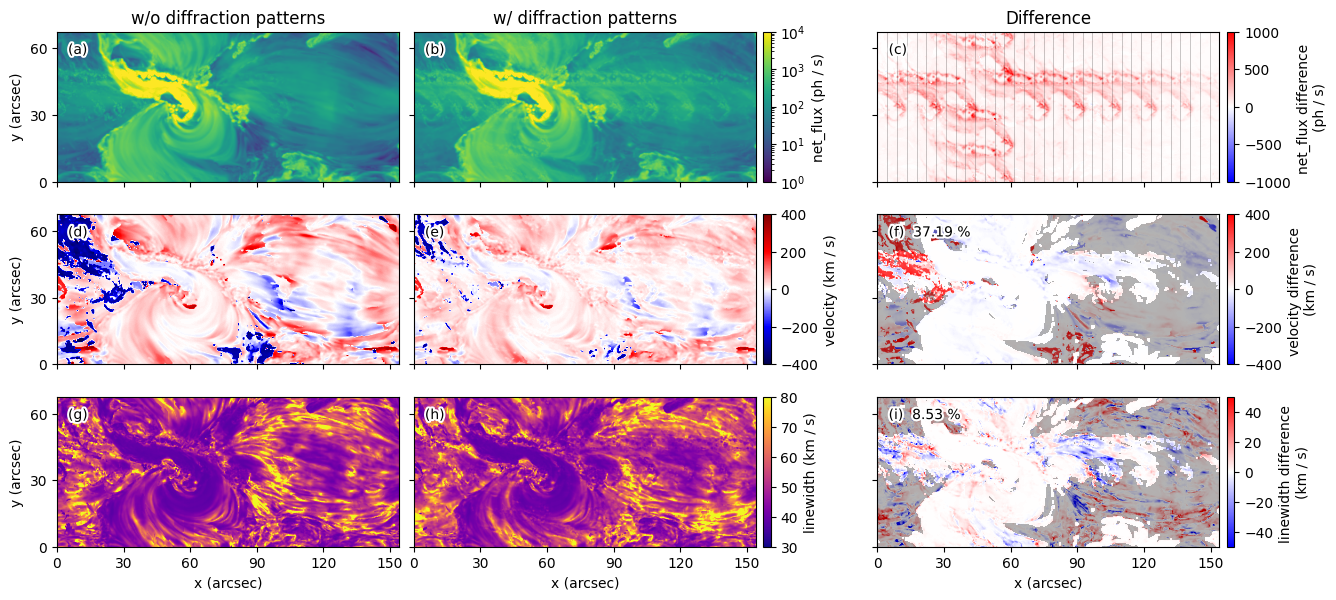

In [116]:
axs = plot_diff2(mom_obs, mom_obs_70lpi, mask_rev_70lpi, outliers_70lpi, show_slits=True)
plt.savefig(fig_path+'comp_diff.png', dpi=200, bbox_inches='tight')

velocity outlier: 13.764255958478454
linewidth outlier: 4.7701973639281565


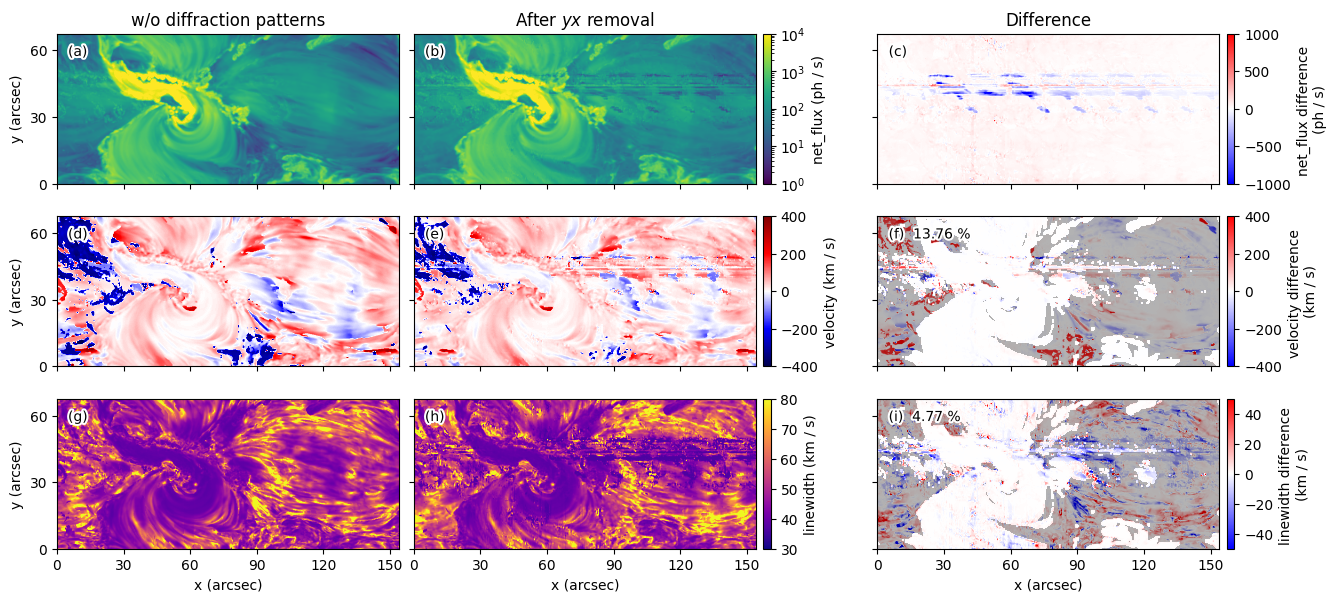

In [117]:
axs = plot_diff2(mom_obs, mom_yx_remove, mask_rev_yx_remove, outliers_yx_remove,  title1='After $yx$ removal')
plt.savefig(fig_path+'comp_yx_removal.png', dpi=200, bbox_inches='tight')

velocity outlier: 0.4116447246430558
linewidth outlier: 0.2243649174856295


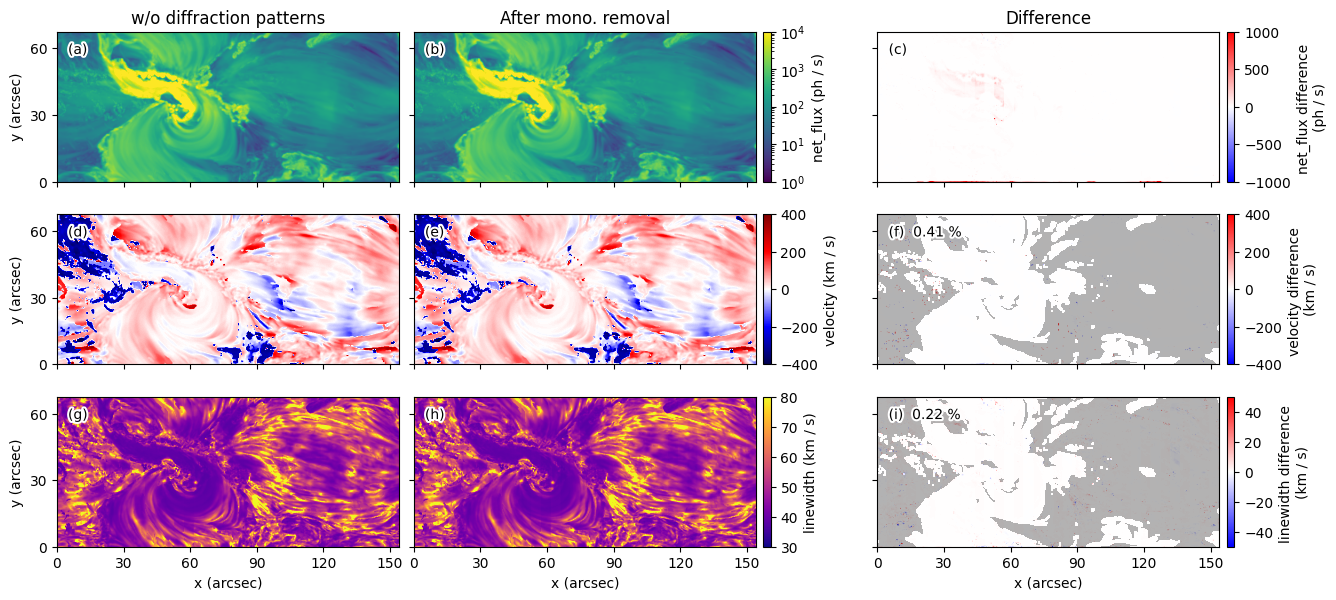

In [118]:
axs = plot_diff2(mom_obs, mom_mono_remove, mask_rev_mono_remove, outliers_mono_remove, title1='After mono. removal')
plt.savefig(fig_path+'comp_mono_removal.png', dpi=200, bbox_inches='tight')

velocity outlier: 1.6421322117582517
linewidth outlier: 0.5723690225838896


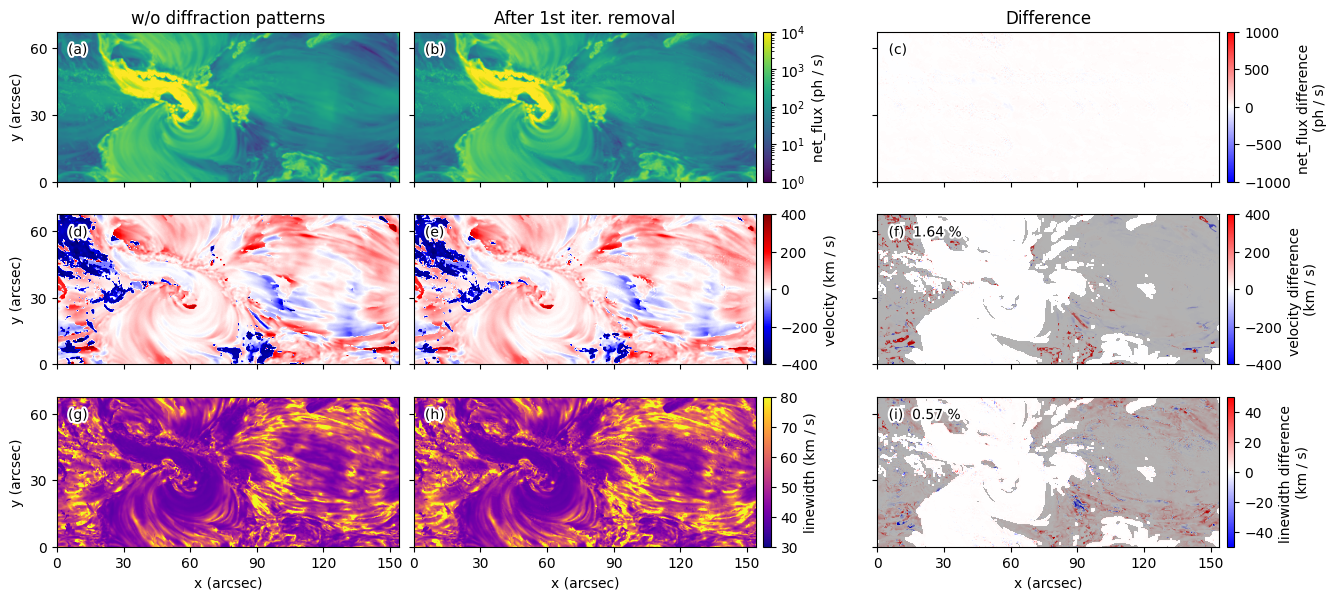

In [119]:
axs = plot_diff2(mom_obs, mom_sub_1st, mask_rev_sub_1st, outliers_sub_1st,  title1='After 1st iter. removal')
plt.savefig(fig_path+'comp_iterative_removal.png', dpi=200, bbox_inches='tight')

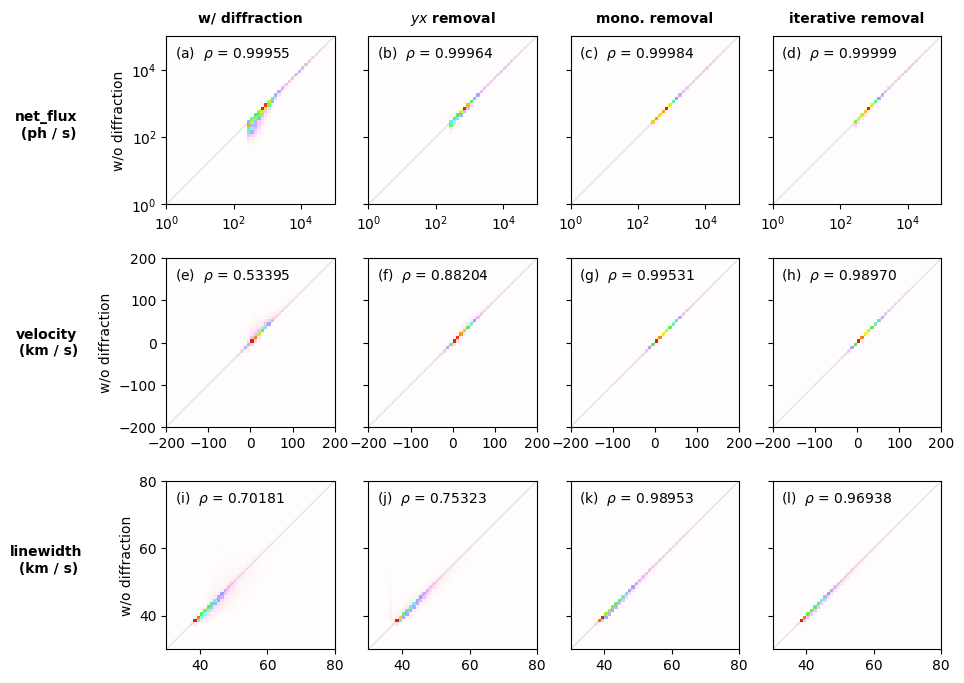

In [124]:
idl_22 = IDL_cmap(22)
fig, axs = plt.subplots(3, 4, figsize=(10, 8))

target = [mom_obs_70lpi, mom_yx_remove, mom_mono_remove, mom_sub_1st]
mask = [mask_all_70lpi, mask_all_yx_remove, mask_all_mono_remove, mask_all_sub_1st] 
name = ['w/ diffraction', 
        '$yx$ removal', 
        'mono. removal', 
        'iterative removal']
lims = [[0, 5], [-200, 200], [30, 80]]
for j, param in enumerate(['net_flux', 'velocity', 'linewidth']):
    for i in range(4):
        ax = axs[j][i]
        # xdata = target[i][param].data.flatten()
        # ydata = mom_obs[param].data.flatten()
        xdata = (target[i][param]*mask[i]['amplitude']).data.flatten()
        ydata = (mom_obs[param]*mask[i]['amplitude']).data.flatten()
        a = np.ma.masked_invalid(xdata)
        b = np.ma.masked_invalid(ydata)
        msk = (~a.mask & ~b.mask)
        coef = np.ma.corrcoef(xdata[msk], ydata[msk])[0][1]
        if param == 'net_flux':
            xdata = np.log10(xdata)
            ydata = np.log10(ydata)
            # log = 'log '
        ax.hist2d(xdata, ydata, bins=50, range=[lims[j], lims[j]], cmap=idl_22)
        ax.plot(lims[j], lims[j], '-k', lw=1, alpha=0.1)
        ax.text(0.05, 0.95, fr'({chr(ord("a") + i+j*4)})  $\rho$ = {coef:.5f}', transform=ax.transAxes, 
               va='top', ha='left')
        ax.set_yticks(ax.get_xticks())        
        if j == 0:
            ax.set_xticklabels([f'$10^{int(s.get_text())}$' for s in ax.get_xticklabels()])
            ax.set_yticklabels([f'$10^{int(s.get_text())}$' for s in ax.get_yticklabels()])
            pos = ax.get_position()
            ax.text(0.5*(pos.x0+pos.x1), pos.y1+0.02, name[i], va='center', ha='center', 
                     weight='bold', transform=fig.transFigure)
        ax.set_yticks(ax.get_xticks())        
        ax.set(aspect='equal', ylabel=f'{log}w/o diffraction', 
               xlim=lims[j], ylim=lims[j])

        if i != 0:
            ax.get_yaxis().set_ticklabels('')
            ax.set_ylabel('')
        else:
            pos = ax.get_position()
            ax.text(pos.x0-0.12, 0.5*(pos.y0+pos.y1), 
                    param+f'\n ({mom_obs[param].attrs["units"]})', 
                    va='center', ha='center', 
                    weight='bold', transform=fig.transFigure)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig(fig_path+'scatter.png', dpi=200, bbox_inches='tight')

In [16]:
def plot_diff(mom_obs, mom_obs_70lpi, 
              title0='w/o diffraction patterns', 
              title1='w/ diffraction patterns', 
              param='net_flux', 
              show_slits=False
             ):
              
    import matplotlib.patheffects as patheffects
    norm = colors.PowerNorm(0.3)
    vmin, vmax = 0, 1e4
    difvmin, difvmax = -1000, 1000
    if param == 'velocity':
        norm = None
        vmin, vmax = -400, 400
        difvmin, difvmax = -100, 100
    if param == 'linewidth':
        norm = None
        vmin, vmax = 0, 100
        difvmin, difvmax = -50, 50
    title0 = '(a) ' + title0
    title1 = '(b) ' + title1
    title2 = '(b) - (a)'
    extent = [mom_obs.x[0], mom_obs.x[-1], mom_obs.y[0], mom_obs.y[-1]]
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    
    mom_obs[param].isel(line=0).plot(norm=norm, vmin=vmin, vmax=vmax, ax=axs[0])
    mom_obs_70lpi[param].isel(line=0).plot(norm=norm, vmin=vmin, vmax=vmax, ax=axs[1])
    (mom_obs_70lpi-mom_obs)[param].isel(line=0).plot(vmin=difvmin, vmax=difvmax, 
                                                     cmap='bwr', ax=axs[2], 
                                                      cbar_kwargs={'label': param+" difference"})
    for ax in axs:
        ax.set_aspect('equal', 'box')
        ax.set_title('')
        ax.get_yaxis().set_ticks(np.arange(4)*20)
        ax.set_ylabel('Solar Y (arcsec)')
        
    axs[2].set_xlabel('Solar X (arcsec)')    
    axs[0].get_xaxis().set_ticklabels([])
    axs[1].get_xaxis().set_ticklabels([])
    title = [title0, title1, title2]
    if show_slits:
        for slit in range(35):
            axs[2].plot([slit*0.4*11]*2, axs[2].get_ylim(), lw=0.5, color='k', alpha=0.5)
        
    
    for i_ in range(3):
        axs[i_].text(axs[i_].get_xlim()[0]+5, 
                     axs[i_].get_ylim()[1]-5, title[i_], 
                     va='top', ha='left', 
                     path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")])
    plt.subplots_adjust(hspace=0.05)
    return axs

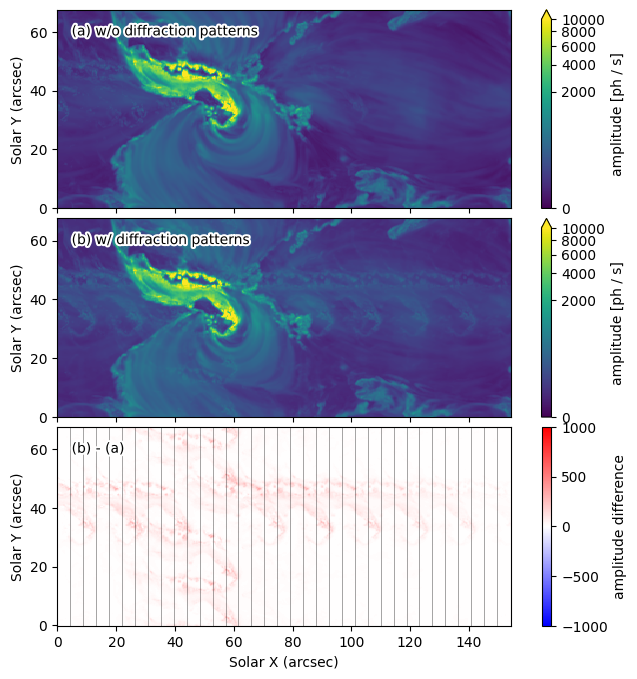

In [47]:
param = 'net_flux'
axs = plot_diff(mom_obs, mom_obs_70lpi, param='amplitude', show_slits=True)
# axs[2].set(xlim = (40, 60), aspect='auto')
# plt.savefig(fig_path+'comp_diff.png', dpi=200, bbox_inches='tight')

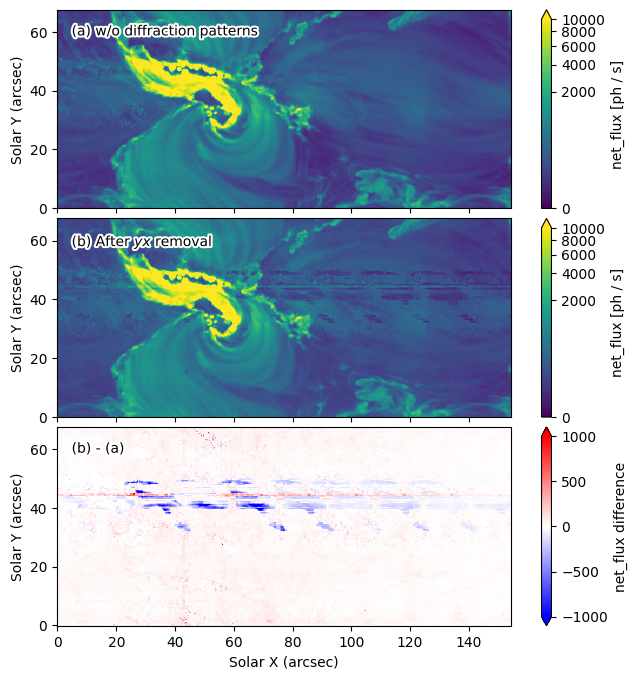

In [48]:
plot_diff(mom_obs, mom_yx_remove, title1='After $yx$ removal', param=param)
plt.savefig(fig_path+'comp_yx_removal.png', dpi=200, bbox_inches='tight')

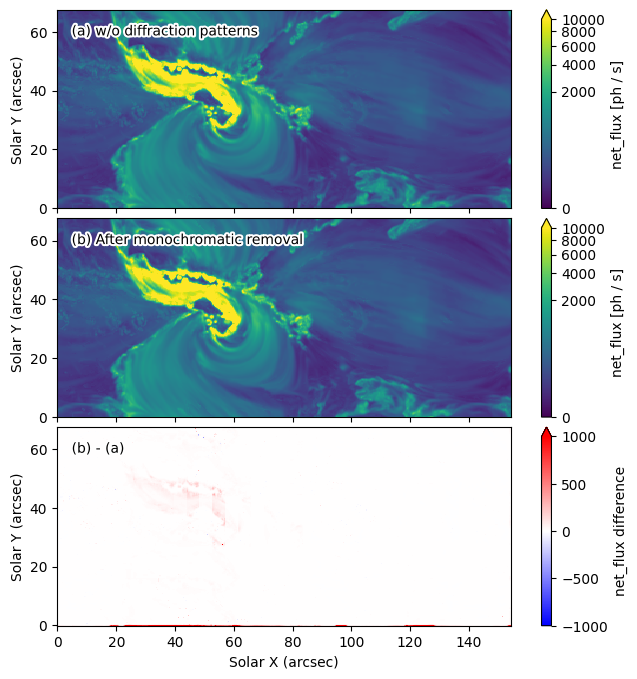

In [49]:
plot_diff(mom_obs, mom_mono_remove, title1='After monochromatic removal', param='net_flux')
plt.savefig(fig_path+'comp_mono_removal.png', dpi=200, bbox_inches='tight')

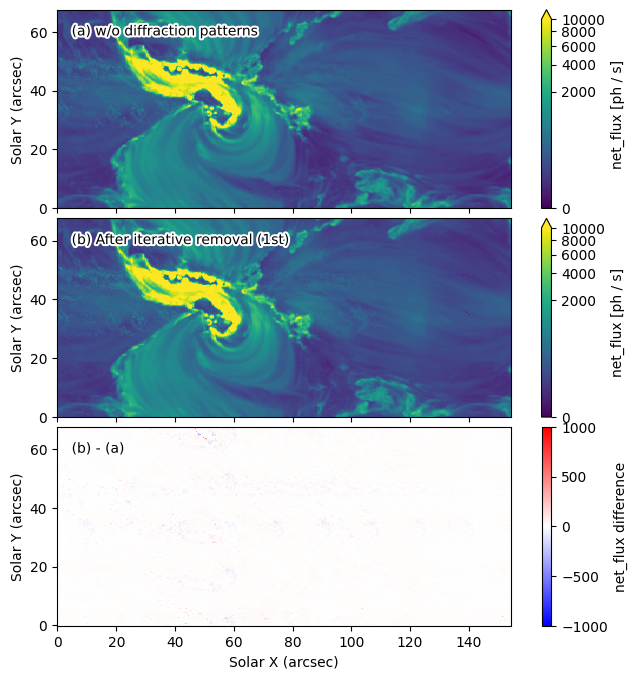

In [50]:
plot_diff(mom_obs, mom_sub_1st, title1='After iterative removal (1st)', param='net_flux')
plt.savefig(fig_path+'comp_iterative_removal.png', dpi=200, bbox_inches='tight')

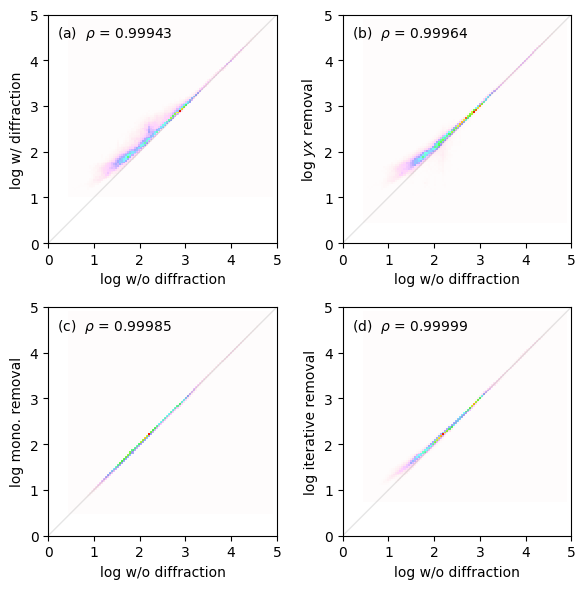

In [53]:
idl_22 = IDL_cmap(22)
fig, axs0 = plt.subplots(2, 2, figsize=(6, 6))
axs = axs0.flatten()
target = [mom_obs_70lpi, mom_yx_remove, mom_mono_remove, mom_sub_1st]
name = ['w/ diffraction', 
        '$yx$ removal', 
        'mono. removal', 
        'iterative removal', 
]
for i, ax in enumerate(axs):
    axs[i].hist2d(np.log10(mom_obs.net_flux.data.flatten()), 
                  np.log10(target[i].net_flux.data.flatten()), bins=100, cmap=idl_22)
    ax.set(aspect='equal', ylabel='log '+name[i], xlabel='log w/o diffraction', 
           xlim=[0, 5], ylim=[0, 5])
    ax.get_yaxis().set_ticks(ax.get_xticks())
    ax.plot([0, 5], [0, 5], '-k', lw=1, alpha=0.1)
    coef = np.corrcoef(mom_obs.net_flux.data.flatten(), target[i].net_flux.data.flatten())[0][1]
    ax.text(0.2, 4.5, fr'({chr(ord("a") + i)})  $\rho$ = {coef:.5f}')
plt.tight_layout()    
plt.savefig(fig_path+'scatter.png', dpi=200, bbox_inches='tight')

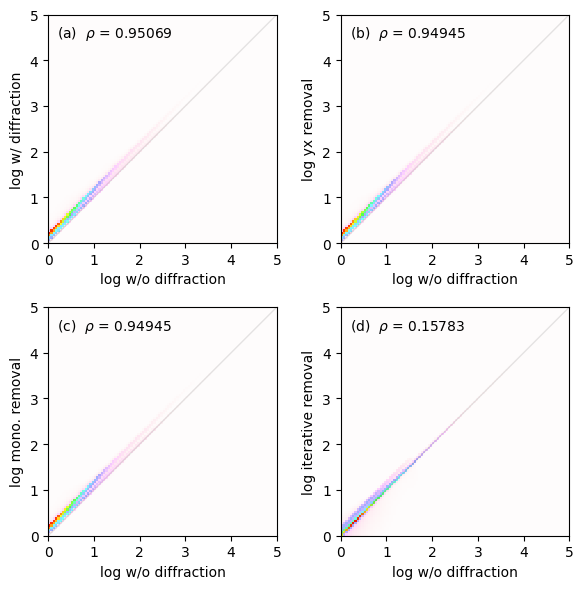

In [45]:
idl_22 = IDL_cmap(22)
fig, axs0 = plt.subplots(2, 2, figsize=(6, 6))
axs = axs0.flatten()
target = [spec_obs_70lpi, spec_yx_remove, spec_mono_remove, spec_sub_1st]
name = ['w/ diffraction', 
        'yx removal', 
        'mono. removal', 
        'iterative removal', 
]
for i, ax in enumerate(axs):
    axs[i].hist2d(np.log10(spec_obs.flux.data.flatten() + 1e-3), 
                  np.log10(target[i].flux.data.flatten() + 1e-3), 
                  bins=100, range=[[0, 5], [0, 5]], 
                  cmap=idl_22)
    ax.set(aspect='equal', ylabel='log '+name[i], xlabel='log w/o diffraction', 
           xlim=[0, 5], ylim=[0, 5])
    ax.get_yaxis().set_ticks(ax.get_xticks())
    ax.plot([0, 5], [0, 5], '-k', lw=1, alpha=0.1)
    coef = np.corrcoef(spec_obs.flux.data.flatten(), target[i].flux.data.flatten())[0][1]
    ax.text(0.2, 4.5, fr'({chr(ord("a") + i)})  $\rho$ = {coef:.5f}')
plt.tight_layout()    
# plt.savefig(fig_path+'scatter.png', dpi=200, bbox_inches='tight')